In [5]:
from src.config import filepaths
from src.utils import construct_sparse_adj_mat, load_json
from src.chemdraw import draw_reaction
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import ipywidgets as widgets
from IPython.display import SVG
from ipywidgets import interact
from scipy.stats import entropy
from collections import defaultdict
from itertools import combinations, product

In [6]:
def axwise_entropy(mat: np.ndarray, axis: int):
    if axis != 0 and axis != 1:
        raise ValueError("Invalid axis. Only 2D arrays supported")
    elif axis == 0:
        axsum = mat.sum(axis=axis).reshape(1, -1)
    elif axis == 1:
        axsum = mat.sum(axis=axis).reshape(-1, 1)
    
    return np.where(axsum != 0, mat / axsum, 0)

def plot_cdf(ax, data, color='black', linestyle='-', label=''):
    data = sorted(data)
    ycdf = np.arange(1, len(data) + 1) / len(data)
    ax.plot(data, ycdf, color=color, linestyle=linestyle, label=label)

In [7]:
# Load stuff

smfp = filepaths['sim_mats']
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
krs = load_json(filepaths['sprhea'] / f"{toc}.json")
rules = pd.read_csv(filepaths['data'] / "minimal1224_all_uniprot.tsv", sep='\t', )
rules.set_index('Name', inplace=True)

sim_metrics = [
    'bag_of_molecules_proteins_x_reactions',
    'rc_agg_r2_proteins_x_reactions',
    'rc_agg_r3_proteins_x_reactions',
    'rc_agg_r4_proteins_x_reactions',
    "rcmcs",
    "mcs",
    "tanimoto",
    "agg_mfp_cosine"
]

sim_mats = {name.removesuffix("_proteins_x_reactions"): np.load(smfp / f"{dataset}_{toc}_{name}.npy")
                for name in sim_metrics}

Constructing sprhea:v3_folded_pt_ns sparse adjacency matrix


In [114]:
# Select pxr and rxr sim mats
cross_sim = 'bag_of_molecules'
rxn_sim = 'rcmcs'

# Get predicted novel postives
diff = sim_mats[cross_sim] - adj
diff = np.array(diff)
crossovers = np.argwhere(diff > 0.5)
crossovers = np.vstack(sorted(crossovers, key=lambda x: diff[*x], reverse=True))
novel_positives = diff[crossovers[:, 0], crossovers[:, 1]].reshape(-1,)
crossover_ids = [(idx_sample[i], idx_feature[j]) for i, j in crossovers]

In [115]:
# Keys are adj mat idx of (prot, novel rxn, known rxns)
novel_triples = defaultdict(lambda : defaultdict(lambda : defaultdict(float)))
novel_pair_sim_stats = {}
novel_sims = []
for p, r in crossovers:
    other_rs = adj[p, :].nonzero()[1]
    other_sims = sim_mats[rxn_sim][r, other_rs]
    novel_pair_sim_stats[(p, r)] = (other_sims.mean(), other_sims.std())
    for o, s in zip(other_rs, other_sims):
        novel_triples[p][r][o] = s
        novel_sims.append(s)

srt_novel_pairs = sorted(novel_pair_sim_stats.keys(), key=lambda x : novel_pair_sim_stats[x][0], reverse=True)

novel_p, novel_r = zip(*novel_pair_sim_stats.keys())
novel_pair_scores = sim_mats[cross_sim][novel_p, novel_r]
novel_pair_scores = dict(zip(novel_pair_sim_stats.keys(), novel_pair_scores))

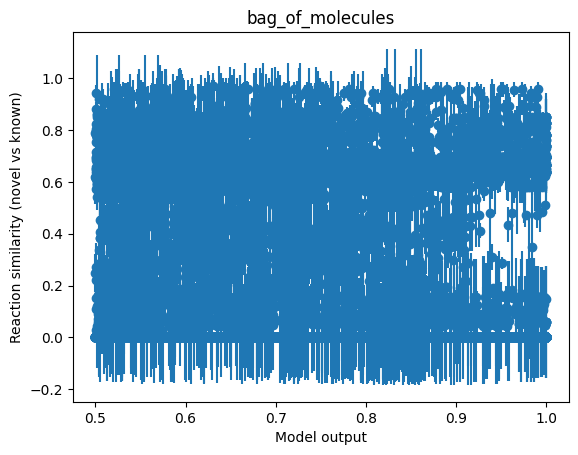

In [116]:
x = novel_pair_scores.values()
mu, sigma = zip(*novel_pair_sim_stats.values())
fig, ax = plt.subplots()
ax.errorbar(x, mu, sigma, fmt="o")
ax.set_title(f"{cross_sim}")
ax.set_ylabel("Reaction similarity (novel vs known)")
ax.set_xlabel("Model output")
plt.show()

In [117]:
most_credible = {}
rsim_lb = 0.2
score_lb = 0.8
for k in novel_pair_sim_stats:
    if novel_pair_sim_stats[k][0] >= rsim_lb and novel_pair_scores[k] >= score_lb:
        most_credible[k] = {'score': novel_pair_scores[k], "rsim": novel_pair_sim_stats[k]}

In [118]:
len(most_credible)

1380

In [123]:
srt_credible = [(i, s) for i, s in enumerate(sorted(most_credible, key= lambda x : most_credible[x]["score"], reverse=True))]
credible_dropdown = widgets.Dropdown(options=srt_credible, value=srt_credible[0][1])

@interact
def display_most_credible(pair = credible_dropdown):
    draw = lambda x : display(SVG(draw_reaction(krs[x]['smarts'], sub_img_size=(300, 200))))
    p, r = pair
    pid = idx_sample[p]
    iid = idx_feature[r]
    js = adj[p, :].nonzero()[1]
    n_prots_per_rxn = np.array([len(adj[:, j].nonzero()[0]) for j in js])
    mu_ppr, sig_ppr = n_prots_per_rxn.mean(), n_prots_per_rxn.std()
    jids = [idx_feature[j] for j in js]
    print(f"Protein ID: {pid}, # known reactions: {len(jids)}")

    print(f"NOVEL: {iid}, Model output: {most_credible[pair]['score']:.2f}")
    draw(iid)

    print(f"KNOWN. Similarity: {most_credible[pair]['rsim'][0]:.2f} pm {most_credible[pair]['rsim'][1]:.2f}, # known enzymes: {mu_ppr:.2f} pm {sig_ppr:.2f}")
    for jid in jids:
        print(f"{jid}")
        draw(jid)

interactive(children=(Dropdown(description='pair', options=((0, (4298, 774)), (1, (4609, 774)), (2, (9554, 774…

In [124]:
# x = np.arange(len(srt_novel_pairs))
# means, stds = zip(*[novel_pair_sim_stats[key] for key in srt_novel_pairs])
# nz_means, nz_stds = zip(*[(m, s) for m, s in zip(means, stds) if m > 0])
# nz_x = np.arange(len(nz_means))

# # Grouped by protein
# fig, ax = plt.subplots()
# ax.errorbar(x=x, y=means, yerr=stds, fmt='.' )
# ax.set_ylabel(f"{rxn_sim}")
# plt.show()

# # CDF
# fig, ax = plt.subplots()
# plot_cdf(ax, novel_sims)
# ax.set_ylim(0, 1.01)
# ax.set_xlim(-0.01, 1)
# ax.set_xlabel(f"{rxn_sim}")
# plt.show()

# # Grouped by protein, non-zero
# fig, ax = plt.subplots(figsize=(20, 2))
# ax.errorbar(x=nz_x, y=nz_means, yerr=nz_stds, fmt='.' )
# ax.set_ylabel(f"{rxn_sim}")
# plt.show()


# # CDF, non-zero
# fig, ax = plt.subplots()
# plot_cdf(ax, [elt for elt in novel_sims if elt > 0])
# ax.set_ylim(0, 1)
# ax.set_xlim(0, 1)
# ax.set_xlabel(f"{rxn_sim}")
# plt.show()

In [126]:
# Benchmark within-protein rcmcs between known reactions

protein_rcmcs_benchmark = {}
for p in range(adj.shape[0]):
    known_rs = adj[p, :].nonzero()[1]
    if len(known_rs) > 1:
        i, j = zip(*combinations(known_rs, 2))
        sims = sim_mats[rxn_sim][i, j]
        protein_rcmcs_benchmark[p] = (sims.mean(), sims.std())

srt_rcmcs_benchmark = sorted(protein_rcmcs_benchmark.keys(), key=lambda x : protein_rcmcs_benchmark[x][0], reverse=True)

x = np.arange(len(srt_rcmcs_benchmark))
means, stds = zip(*[protein_rcmcs_benchmark[key] for key in srt_rcmcs_benchmark])
nz_means, nz_stds = zip(*[(m, s) for m, s in zip(means, stds) if m > 0])
nz_x = np.arange(len(nz_means))

# # Plot
# fig, ax = plt.subplots()
# ax.errorbar(x=x, y=means, yerr=stds, fmt='.' )
# ax.set_ylabel(f"{rxn_sim}")
# plt.show()

# fig, ax = plt.subplots(figsize=(20, 2))
# ax.errorbar(x=nz_x, y=nz_means, yerr=nz_stds, fmt='.' )
# ax.set_ylabel(f"{rxn_sim}")
# plt.show()

In [127]:
# Examine low-RCMCS, within-enzyme pairs
intra_enzyme_pairs = {}
for p in range(0, adj.shape[0], 10):
    known_rs = adj[p, :].nonzero()[1]
    if len(known_rs) > 1:
        for i, j in combinations(known_rs, 2):
            intra_enzyme_pairs[(p, i, j)] = sim_mats[rxn_sim][i, j]

srt_intra_enzyme_pairs = sorted(intra_enzyme_pairs, key=lambda x : intra_enzyme_pairs[x])

intra_dropdown = widgets.Dropdown(options=srt_intra_enzyme_pairs, value=srt_intra_enzyme_pairs[0])

@interact
def display_intra_pairs(pair = intra_dropdown):
    p, i, j = pair
    pid = idx_sample[p]
    iid = idx_feature[i]
    jid = idx_feature[j]
    print(f"Protein ID: {pid}")
    print(f"Reaction pair: {iid}, {jid}")
    print(f"RCMCS: {intra_enzyme_pairs[pair]}")
    print(f"Rules: {krs[iid]['min_rules']}, {krs[jid]['min_rules']}")

    for id in [iid, jid]:
        svg = SVG(draw_reaction(krs[id]['smarts'], sub_img_size=(300, 200)))
        display(svg)

interactive(children=(Dropdown(description='pair', options=((50, 81, 84), (50, 82, 84), (50, 83, 84), (50, 84,…

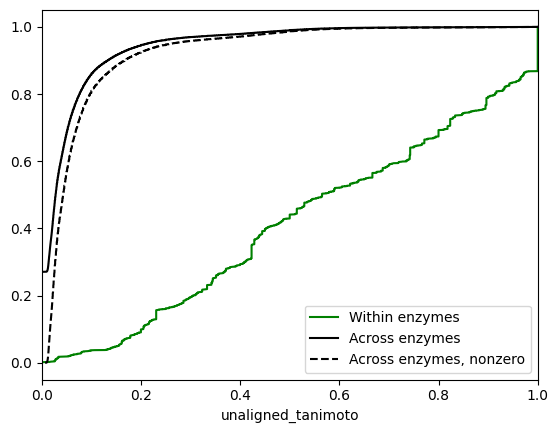

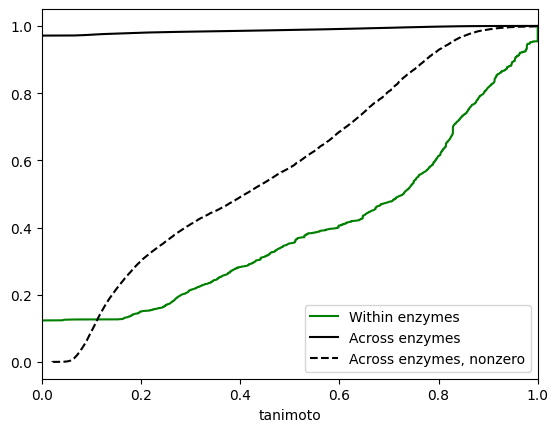

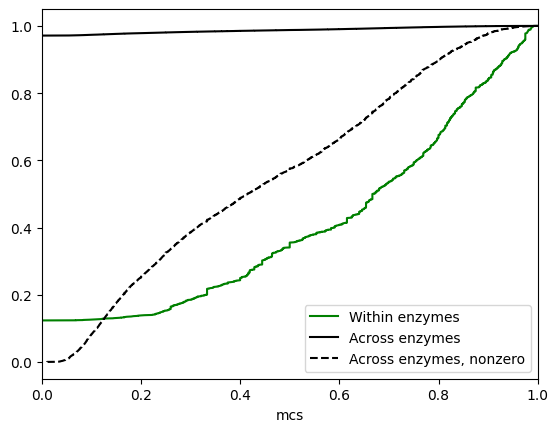

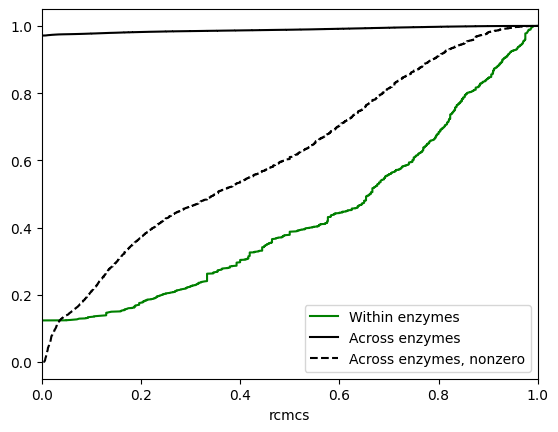

In [9]:
# Intra / cross protein rcmcs displayed as straight cdf
# as opposed to mini distributions

rsims = ['unaligned_tanimoto', 'tanimoto', 'mcs', 'rcmcs']

for rsim in rsims:
    intra = np.array([])
    inter = np.array([])
    ridxs = set([i for i in range(adj.shape[1])])
    for p in range(0, adj.shape[0], 50):
        known_rs = adj[p, :].nonzero()[1]
        if len(known_rs) > 1:
            i, j = zip(*combinations(known_rs, 2))
            in_sims = sim_mats[rsim][i, j]
            intra = np.concatenate((intra, in_sims))

        
        not_known = np.array(list(ridxs - set(known_rs)))
        i, j = zip(*product(known_rs, not_known))
        out_sims = sim_mats[rsim][i, j]
        inter = np.concatenate((inter, out_sims))

    fig, ax = plt.subplots()
    plot_cdf(ax, intra, color='green', label="Within enzymes")
    plot_cdf(ax, inter, color='black', label="Across enzymes")
    plot_cdf(ax, [elt for elt in inter if elt > 0], color='black', linestyle='--', label="Across enzymes, nonzero")
    ax.set_xlabel(rsim)
    ax.set_xlim(0, 1)
    ax.legend()
    plt.show()